# Importación de librerías



In [2]:
!pip install regex
!pip install demoji
!pip install plotly
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re

import regex
import demoji

import numpy as np
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Paso 1: Definir funciones necesarias


In [4]:
# Patrón regex para identificar el comienzo de cada línea del txt con la fecha y la hora
def IniciaConFechaYHora(s):
    patron = r'^(\d{1,2})/(\d{1,2})/(\d{2,4}), (\d{1,2}):(\d{2}) -'
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    return bool(resultado)

# Patrón para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = ['Betty Flores Rosales:', 'Gato:']
    patron = '^' + '|'.join(patrones)
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    return bool(resultado)

# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):
    # Ejemplo: '29/11/2023, 01:49 - Sandreke: Todos debemos aprender a analizar datos'
    splitLinea = linea.split(' - ')
    FechaHora = splitLinea[0]  # '29/11/2023, 01:49'
    splitFechaHora = FechaHora.split(', ')
    Fecha = splitFechaHora[0]  # '29/11/2023'
    Hora = splitFechaHora[1]   # '01:49'

    MensajeCompleto = ' - '.join(splitLinea[1:])  # Puede contener múltiples ' - '

    # Buscar el primer patrón de miembro en el mensaje completo
    for patron in ['Betty Flores Rosales:', 'Gato:']:
        if patron in MensajeCompleto:
            Miembro, Mensaje = MensajeCompleto.split(patron, 1)
            Miembro = patron[:-1]  # Quitar los dos puntos al final del miembro
            Mensaje = Mensaje.strip()
            return Fecha, Hora, Miembro, Mensaje

    # Si no se encuentra ningún miembro
    return Fecha, Hora, None, MensajeCompleto.strip()


# Paso 2: Obtener el dataframe del archivo txt del chat

In [5]:
# Leer el archivo txt descargado del chat de WhatsApp
# RutaChat = 'Data/chat.txt'
RutaChat = '/content/drive/MyDrive/mes-2/Data/chat.txt'

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    while True:
        linea = fp.readline()
        if not linea:
            break
        linea = linea.strip()
        if IniciaConFechaYHora(linea): # Si cada línea del txt coincide con el patrón fecha y hora
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            DatosLista.append([Fecha, Hora, Miembro, Mensaje])
        elif DatosLista: # Si la línea no comienza con fecha y hora, se asume que es continuación del mensaje anterior
            DatosLista[-1][-1] += ' ' + linea

# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%Y", errors='coerce')

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Resetear el índice
df.reset_index(drop=True, inplace=True)

df

,Fecha,Hora,Miembro,Mensaje
0,2023-11-29,01:49,Gato,Buenas madrugadas
1,2023-11-29,01:50,Betty Flores Rosales,Ya duermee
2,2023-11-29,01:50,Gato,"Disculpe necesito su correo, contraseña, sus n..."
3,2023-11-29,01:50,Gato,Gracias
4,2023-11-29,01:50,Gato,😌
...,...,...,...,...
19419,2024-05-29,16:03,Betty Flores Rosales,"Que feo que ha estado, pero vos si sueñas con ..."
19420,2024-05-29,16:03,Betty Flores Rosales,No me acuerdo 😭
19421,2024-05-29,16:03,Betty Flores Rosales,Si mi amor mucho mucho 🥺
19422,2024-05-29,16:04,Betty Flores Rosales,No no tu no sabes hacer caso 😝


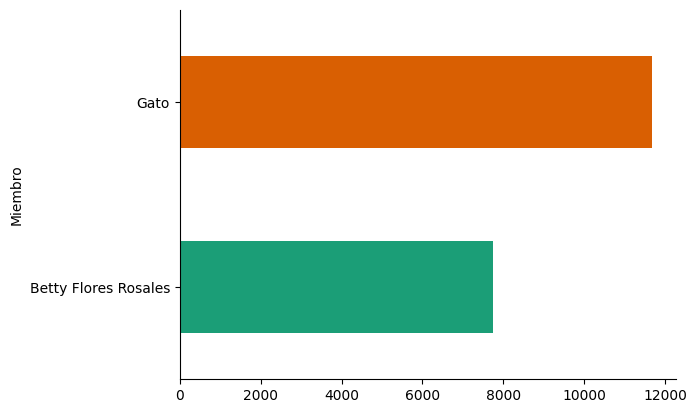

In [6]:
# @title Miembro

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Miembro').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Filtrar el chat por fecha de acuerdo a lo requerido

In [7]:
#start_date = '2023-01-01'
#end_date = '2024-05-29'

#df = df[(df['Fecha'] >= start_date) & (df['Fecha'] <= end_date)]
df

,Fecha,Hora,Miembro,Mensaje
0,2023-11-29,01:49,Gato,Buenas madrugadas
1,2023-11-29,01:50,Betty Flores Rosales,Ya duermee
2,2023-11-29,01:50,Gato,"Disculpe necesito su correo, contraseña, sus n..."
3,2023-11-29,01:50,Gato,Gracias
4,2023-11-29,01:50,Gato,😌
...,...,...,...,...
19419,2024-05-29,16:03,Betty Flores Rosales,"Que feo que ha estado, pero vos si sueñas con ..."
19420,2024-05-29,16:03,Betty Flores Rosales,No me acuerdo 😭
19421,2024-05-29,16:03,Betty Flores Rosales,Si mi amor mucho mucho 🥺
19422,2024-05-29,16:04,Betty Flores Rosales,No no tu no sabes hacer caso 😝


# Paso 3: Estadísticas de mensajes, multimedia, emojis y links
Total de mensajes, multimedia, emojis y links enviados

In [8]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje)  # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if demoji.replace(caracter) != caracter:
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x))) # Se agrega columna 'URLs'
links = sum(df['URLs'])

# Obtener la cantidad de encuestas
encuestas = df[df['Mensaje'] == 'POLL:'].shape[0]

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links', 'Encuestas'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links, encuestas]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df


,Cantidad
Tipo,
Mensajes,19424
Multimedia,3386
Emojis,11293
Links,40
Encuestas,0


Emojis más usados

In [9]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji').head(10)

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df

Número emojis únicos usados:  10 



,Cantidad
Emoji,
🥺,4366
🙄,1842
😭,1425
😎,832
😡,524
😘,385
🥲,244
😒,241
😂,162


In [10]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, hole=.3, template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20)
fig.update_layout(title={'text': '🤗 Emojis que más usamos', 'y':0.96, 'x':0.5, 'xanchor': 'center'}, font=dict(size=17))
fig.show()

# Paso 4: Estadísticas de los miembros del grupo
Miembros más activos

In [11]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos['% Mensaje'] = (df_MiembrosActivos['Mensaje'] / df_MiembrosActivos['Mensaje'].sum()) * 100
df_MiembrosActivos

,Miembro,Mensaje,% Mensaje
1,Gato,11672,60.09061
2,Betty Flores Rosales,7752,39.90939


Estadísticas por miembro

In [12]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,Letras,Palabras
19419,2024-05-29,16:03,Betty Flores Rosales,"Que feo que ha estado, pero vos si sueñas con ...",[😝],0,66,14
19420,2024-05-29,16:03,Betty Flores Rosales,No me acuerdo 😭,[😭],0,15,4
19421,2024-05-29,16:03,Betty Flores Rosales,Si mi amor mucho mucho 🥺,[🥺],0,24,6
19422,2024-05-29,16:04,Betty Flores Rosales,No no tu no sabes hacer caso 😝,[😝],0,30,8
19423,2024-05-29,16:05,Betty Flores Rosales,Jajaja oyee yo si te extraño y te extraño mucho 🥺,[🥺],0,49,11


In [13]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
    lista = []
    # Filtrar mensajes de un miembro en específico
    miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

    # Agregar a la lista el número total de mensajes enviados
    lista.append(miembro_df.shape[0])

    # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
    palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
    lista.append(palabras_por_msj)

    # Agregar a la lista el número de mensajes multimedia enviados
    multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
    lista.append(multimedia)

    # Agregar a la lista el número total de emojis enviados
    emojis = sum(miembro_df['Emojis'].str.len())
    lista.append(emojis)

    # Agregar a la lista el número total de links enviados
    links = sum(miembro_df['URLs'])
    lista.append(links)

    # Asignar la lista como valor a la llave del diccionario
    dictionario[miembros[i]] = lista

print(dictionario)


{'Gato': [10726, 10.577848219280254, 946, 10059, 27], 'Betty Flores Rosales': [5312, 7.797063253012048, 2440, 1234, 13]}


In [14]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df = miembro_stats_df.sort_values(by=['Mensajes'], ascending=False)
miembro_stats_df

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Gato,10726,10.577848,946,10059,27
Betty Flores Rosales,5312,7.797063,2440,1234,13


# Paso 5: Estadísticas del comportamiento del grupo

In [15]:
# Convertir la columna Hora a datetime para obtener rangoHora en formato de 24 horas
df['Hora'] = pd.to_datetime(df['Hora'], format='%H:%M', errors='coerce')

# Eliminar las filas con fechas o horas no convertibles
df = df.dropna(subset=['Fecha', 'Hora'])

# Define a function to create the "Range Hour" column
def create_range_hour(hour):
    start_hour = hour.hour
    end_hour = (hour + pd.Timedelta(hours=1)).hour
    return f'{start_hour:02d} - {end_hour:02d} h'

# Apply the function to create the "Range Hour" column
df['rangoHora'] = df['Hora'].apply(create_range_hour)

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna(subset=['Miembro', 'Mensaje'])

# Resetear el índice
df.reset_index(drop=True, inplace=True)

df

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,rangoHora
0,2023-11-29,1900-01-01 01:49:00,Gato,Buenas madrugadas,[],0,01 - 02 h
1,2023-11-29,1900-01-01 01:50:00,Betty Flores Rosales,Ya duermee,[],0,01 - 02 h
2,2023-11-29,1900-01-01 01:50:00,Gato,"Disculpe necesito su correo, contraseña, sus n...",[],0,01 - 02 h
3,2023-11-29,1900-01-01 01:50:00,Gato,Gracias,[],0,01 - 02 h
4,2023-11-29,1900-01-01 01:50:00,Gato,😌,[😌],0,01 - 02 h
...,...,...,...,...,...,...,...
19419,2024-05-29,1900-01-01 16:03:00,Betty Flores Rosales,"Que feo que ha estado, pero vos si sueñas con ...",[😝],0,16 - 17 h
19420,2024-05-29,1900-01-01 16:03:00,Betty Flores Rosales,No me acuerdo 😭,[😭],0,16 - 17 h
19421,2024-05-29,1900-01-01 16:03:00,Betty Flores Rosales,Si mi amor mucho mucho 🥺,[🥺],0,16 - 17 h
19422,2024-05-29,1900-01-01 16:04:00,Betty Flores Rosales,No no tu no sabes hacer caso 😝,[😝],0,16 - 17 h


Número de mensajes por rango de hora

In [16]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
mensajes_hora = df.groupby('rangoHora').count().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(mensajes_hora, x='rangoHora', y='# Mensajes por hora', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con ella ❤️ por hora', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

Número de mensajes por día

In [17]:
# Crear una columna 'DiaSemana' con el nombre del día de la semana
df['DiaSemana'] = df['Fecha'].dt.day_name()

# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('DiaSemana')['# Mensajes por día'].sum().reset_index()

# Ordenar los días de la semana
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
date_df['DiaSemana'] = pd.Categorical(date_df['DiaSemana'], categories=dias_ordenados, ordered=True)
date_df = date_df.sort_values('DiaSemana')

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='DiaSemana', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con ella ❤️ por día', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
    font=dict(size=17)
)
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Día', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

Número de mensajes a través del tiempo

In [18]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha')['# Mensajes por día'].sum().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Mensajes con ella ❤️ a lo largo del tiempo', 'y': 0.96, 'x': 0.5, 'xanchor': 'center'},
    font=dict(size=17)
)
fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

Word Cloud de palabras más usadas

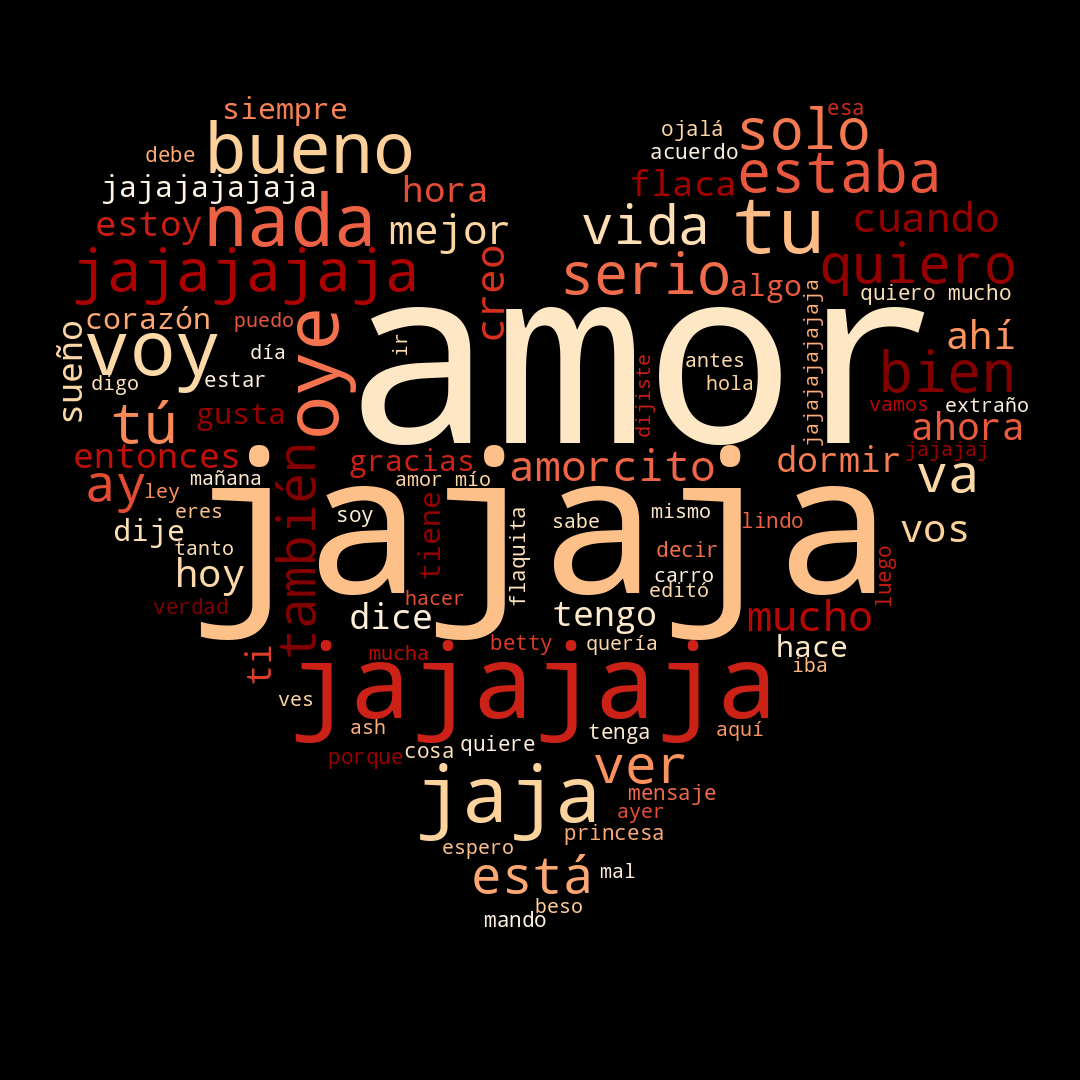

In [19]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                              'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic','nos', 'ya', 'hay', 'esta',
                              'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https','Multimedia','omitido',
                              'y', 'mi', 'o', 'q', 'yo', 'al', 'fue', 'era', 'pues', 'ese', 'sea', 've', 'ni', 'sé'])

#mask = np.array(Image.open('Resources/heart.jpg'))
mask = np.array(Image.open('/content/drive/MyDrive/mes-2/Resources/heart.jpg'))

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
    palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords,
                      max_words=100, min_font_size = 5,
                      mask = mask, colormap='OrRd',).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud.to_image()

Análisis de sentimientos

In [22]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Descargar los recursos necesarios de nltk
nltk.download('vader_lexicon')

# Inicializar el analizador de sentimientos
sid = SentimentIntensityAnalyzer()

# Analizar el sentimiento de cada mensaje
df['Sentimiento'] = df['Mensaje'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Clasificar el sentimiento
df['Sentimiento_clasificacion'] = df['Sentimiento'].apply(lambda x: 'Positivo' if x > 0 else ('Negativo' if x < 0 else 'Neutro'))

# Mostrar los resultados
df[['Mensaje', 'Sentimiento', 'Sentimiento_clasificacion']]


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Mensaje,Sentimiento,Sentimiento_clasificacion
0,Buenas madrugadas,0.0000,Neutro
1,Ya duermee,0.0000,Neutro
2,"Disculpe necesito su correo, contraseña, sus n...",0.0000,Neutro
3,Gracias,0.0000,Neutro
4,😌,0.0000,Neutro
...,...,...,...
19419,"Que feo que ha estado, pero vos si sueñas con ...",0.3400,Positivo
19420,No me acuerdo 😭,-0.2960,Negativo
19421,Si mi amor mucho mucho 🥺,0.6124,Positivo
19422,No no tu no sabes hacer caso 😝,-0.6808,Negativo


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


"< Multimedia omitido" aparece 3386 veces
"Multimedia omitido >" aparece 3386 veces
"> < Multimedia" aparece 1336 veces
"omitido > <" aparece 1321 veces
"? ? ?" aparece 205 veces
"omitido > Jajaja" aparece 205 veces
"? < Multimedia" aparece 178 veces
"mi amor ," aparece 172 veces
"Te quiero mucho" aparece 127 veces
"omitido > Jajajaja" aparece 122 veces


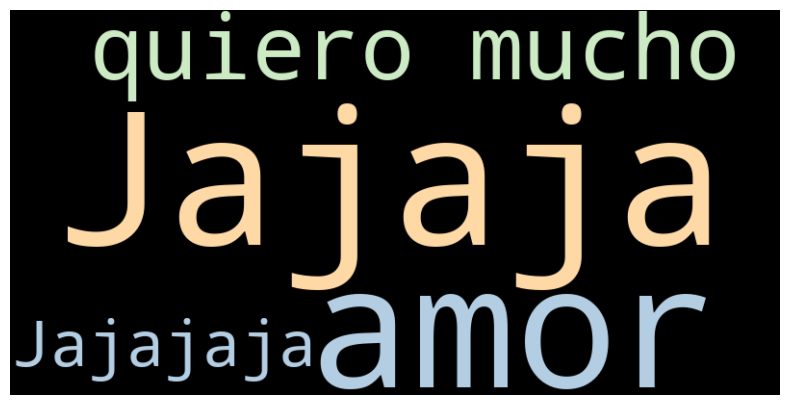

In [23]:
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

# Asegúrate de tener las bibliotecas necesarias
import nltk
nltk.download('punkt')

# Función para encontrar las frases más comunes
def encontrar_frases_comunes(df, n=3, top_n=10):
    # Unir todos los mensajes en un solo texto
    all_text = ' '.join(df['Mensaje'])

    # Tokenizar el texto en palabras
    tokens = word_tokenize(all_text)

    # Crear una lista de frases de longitud n
    frases = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

    # Contar la frecuencia de cada frase
    frase_counter = Counter(frases)

    # Obtener las frases más comunes
    frases_comunes = frase_counter.most_common(top_n)

    return frases_comunes

# Leer los datos desde el archivo de chat (asumiendo que ya tienes el dataframe df)
# df = pd.read_csv('ruta_al_archivo.csv')

# Encontrar las frases más comunes (por ejemplo, frases de 3 palabras)
frases_comunes = encontrar_frases_comunes(df, n=3, top_n=10)

# Mostrar las frases más comunes
for frase, freq in frases_comunes:
    print(f'"{frase}" aparece {freq} veces')

# Opcional: Crear una nube de palabras para las frases más comunes
frase_text = ' '.join([frase for frase, freq in frases_comunes for _ in range(freq)])
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Pastel1').generate(frase_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
